# Basic Sentiment Analysis on submissions in subreddit "wallstreetbets"

# Hypothesis

+ **Sentiment analysis of posts from the Wallstreetbets subreddit provides a reliable way to gauge stock market sentiment.**

## Import packages

In [115]:
#General
import os
import re
import pandas as pd
#Reddit wrapper API
import praw
#NLP
import nltk
from nltk import word_tokenize, corpus
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('words')
nltk.download('punkt')
nltk.download('vader-lexicon')
from wordcloud import WordCloud, STOPWORDS    
#Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from raceplotly.plots import barplot


[nltk_data] Downloading package words to /home/user/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /home/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Error loading vader-lexicon: Package 'vader-lexicon' not
[nltk_data]     found in index


# Collect data with API

The used data is scraped from submissions in subbreddit "WallstreetBets" with the Python API Wrapper "PRAW" from Reddit. To run the API, you have to create a App, https://www.reddit.com/prefs/apps. <br>
For safety reasons, I did not include the client_id and client_secret in the notebook.

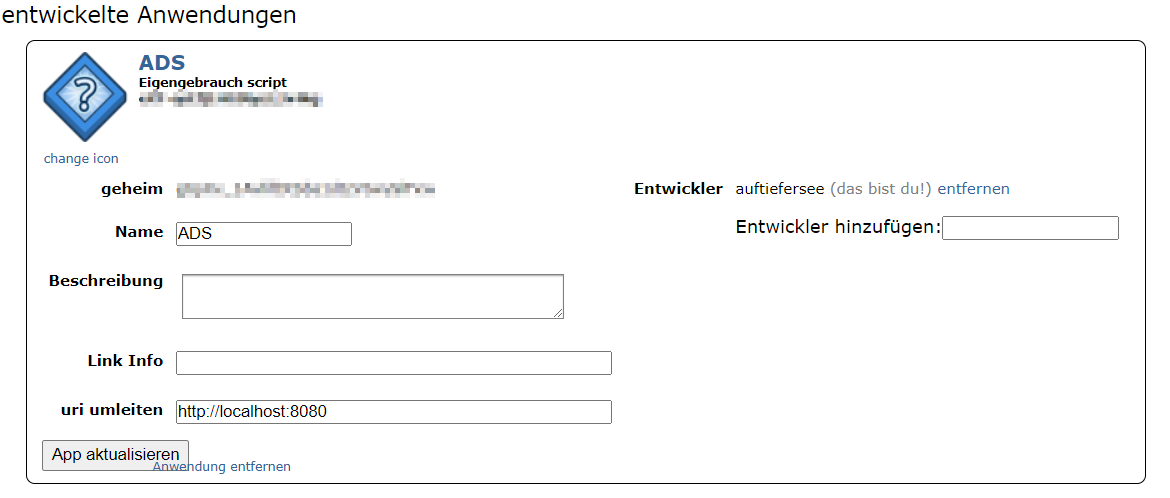

In [2]:
user_agent = "Scraper 1.0 by /u/auftiefersee"
wsb = praw.Reddit(
    client_id="replacewithyourownclientid",
    client_secret="replacewithyourownclientsecret",
    user_agent=user_agent,
    username="auftiefersee",
    password="aufhohersee"
).subreddit("wallstreetbets")

In [3]:
# download data for analysis
def download_data(ranked_by="hot", **kwargs):
    """
    ranked_by: str, either hot or top or new
    """
    submissions = []
    if ranked_by == "hot":
        response = wsb.hot(**kwargs)
    elif ranked_by == "top":
        response = wsb.top(**kwargs)
    elif ranked_by == "new":
        response = wsb.new(**kwargs)
    else:
        raise ValueError("ranked_by must be either hot or top or new")

    for submission in response:
        post = []
        post = [
            submission.title,
            submission.selftext,
            submission.created_utc,
            submission.score,
        ]
        # extract comments from commentforest
        submission.comments.replace_more(limit=0)
        comment = ""
        for top_comment in submission.comments[:100]:
            comment = str(top_comment.body) + ""
        post.append(comment)
        submissions.append(post)
    df = pd.DataFrame(
        submissions,
        columns=[
            "title",
            "content",
            "date",
            "score",
            "comment",
        ],
    )
    df["date"] = pd.to_datetime(df["date"], dayfirst=True, unit="s")
    fp = "data/{}_subs.csv".format(ranked_by)
    try:
        os.makedirs(os.path.split(fp)[0])
    except FileExistsError:
        pass

    df.to_csv(fp)

In [4]:
# download top 1000 hot and top 1000 score submission via API and combined them into one dataframe for learning
#since the download takes a long time and dataset is alredy provided, we won't run it
#download_data('hot', limit=1000)
#download_data('top', limit=1000, time_filter='month')
#total_subs = hot_subs.append(top_subs, ignore_index=True).drop_duplicates()

# Data preparation

In [5]:
df1 = pd.read_csv("top_subs.csv")
df2 = pd.read_csv("hot_subs.csv")
#combine datasets
total_subs = pd.concat([df1, df2])

In [6]:
#number of rows and columns
print(total_subs.shape)

(1367, 7)


In [7]:
total_subs.head(5)

,Unnamed: 0,title,flair,content,date,score,comment
0,0,Following this legend today made my drive home...,Meme,NaN,2023-04-17 23:26:45,33247,How is this turd still afloat?
1,1,One does not simply become profitable…,Meme,NaN,2023-04-15 17:19:32,33199,First 4s of that song would make a hot sample ...
2,2,kisd on reddit🙂,Meme,NaN,2023-04-22 23:52:51,30713,Pete Davidson's son David Davidson with your s...
3,3,AI chatbot to replace human order-takers at We...,Meme,NaN,2023-05-10 00:37:47,27043,It’s going to be real awkward trying to focus ...
4,4,"I will be suing Robinhood for $295,000 if they...",Discussion,"One week ago, I reached out of Robinhood to in...",2023-05-01 13:41:29,24181,Dude. He said in Exhibit 2 that “based on the ...


In [8]:
oldest_entry = total_subs['date'].min()
newest_entry = total_subs['date'].max()

print("Oldest Entry:", oldest_entry)
print("Newest Entry:", newest_entry)


Oldest Entry: 2023-04-15 03:14:03
Newest Entry: 2023-05-15 20:57:11


In [9]:
#drop column
total_subs.drop(columns='Unnamed: 0', inplace=True)
#drop rows with duplicate entrys
total_subs.drop_duplicates(subset=['title', 'date'], keep='first', inplace=True)

In [11]:
#function to clean the text
def clean(text):
    #convert to lower case
    text = text.lower()

    # Replacing handler with empty string
    text = re.sub('@[^\s]+','',text)

    # Replacing URLs with empty string
    text = re.sub(r"http\S+", "",text)

    # Remove all the special characters
    text = ' '.join(re.findall(r'\w+', text))

    # Replacing Single Characters with Empty String
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    # Remove Extra Spaces
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    return text

# EDA

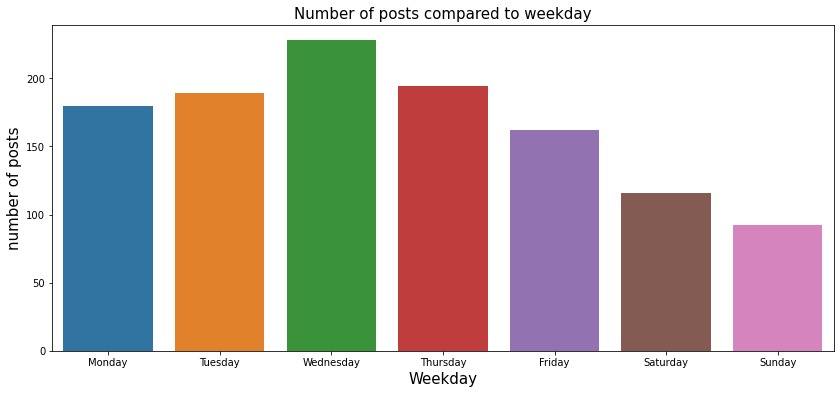

In [10]:
total_subs['date'] = pd.to_datetime(total_subs['date'])

#create week
day_of_the_week = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
days_order = list(day_of_the_week.values())

#add weekday to dataset
total_subs['weekday'] = total_subs['date'].apply(lambda x : day_of_the_week[x.weekday()])

#plot
xs = total_subs['weekday'].value_counts().index
ys = total_subs['weekday'].value_counts().values

plt.figure(figsize=(14,6))

sns.barplot(x=xs, y=ys, order=days_order)

plt.title("Number of posts compared to weekday", fontsize=15)

plt.xlabel("Weekday", fontsize=15)
plt.ylabel("number of posts", fontsize=15)

plt.show()

The most submissions are on wednesday, in the middle of the business week. There are significantly less posts on the weekend, when the markets are closed.

In [60]:
#new dataset, apply function to clean the texts
cleaned_df = total_subs[['title', 'comment']].copy()
cleaned_df.dropna(inplace=True)
cleaned_df = cleaned_df.apply(lambda x: x.apply(clean))

In [61]:
print("There are ", cleaned_df.shape[0], "entrys in our dataset.")

There are  1160 entrys in our dataset.


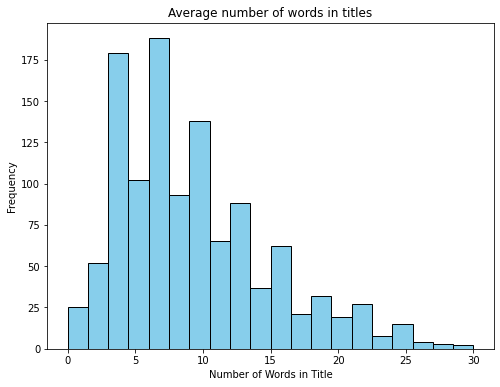

In [62]:
#plot to see the avaerge length of the titles.
len_title = [len(word_tokenize(text)) for text in cleaned_df['title']]
plt.figure(figsize=(8, 6))
plt.hist(len_title, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Number of Words in Title')
plt.ylabel('Frequency')
plt.title('Average number of words in titles')
plt.show()

The titles are mostly between 4 - 9 words long.

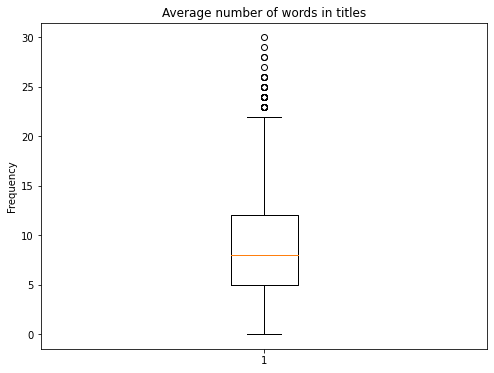

In [63]:
plt.figure(figsize=(8, 6))
plt.boxplot(len_title)
plt.ylabel('Frequency')
plt.title('Average number of words in titles')
plt.show()

The boxplot confirms the suggestion from the histogram and shows, that there are outliers in the upper range.

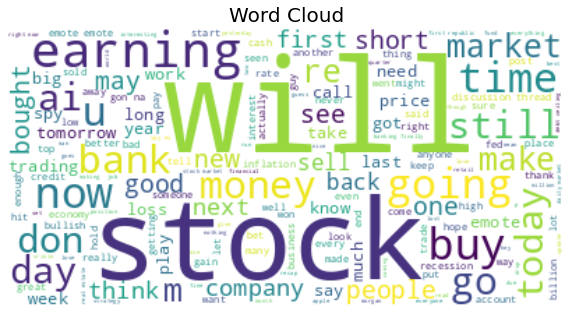

In [16]:
#tokenize 
word_tokens = [word_tokenize(text) for text in cleaned_df['comment'] + cleaned_df['title']]
english_words = set(corpus.words.words())
word_cloud_string = ""

for word_list in word_tokens:
    for word in word_list:
        if word.lower() in english_words:
            word_cloud_string += word + " "

description_stopwords = set(STOPWORDS)

my_word_cloud = WordCloud(background_color='white', stopwords=description_stopwords).generate(word_cloud_string)
plt.figure(figsize=(10, 20))
plt.imshow(my_word_cloud, interpolation='bilinear')
plt.title("Word Cloud", fontsize=20)
plt.axis('off')
plt.show()


The word cloud doesnt show any specific term which could show any show seasonality or trend during the timeframe.

# Sentiment Analysis

In [87]:
#function to run sentiment analysis
def sentiment(sia, text):
    if sia.polarity_scores(text)["compound"] > 0:
        return "Positive"
    elif sia.polarity_scores(text)["compound"] < 0:
        return "Negative"
    else:
        return "Neutral"

sia = SentimentIntensityAnalyzer()    


In [88]:
#reset index so sentiment analysis can be done
cleaned_df.reset_index(drop=True, inplace=True)

#apply sentiment anlysis
total_subs['sentiment'] = cleaned_df.apply(lambda row: sentiment(sia, f"{row['title']} {row['comment']}") if pd.notnull(row['title']) and pd.notnull(row['comment']) else "", axis=1)

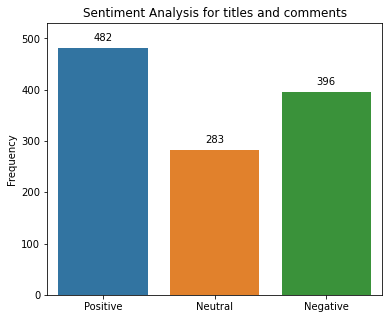

Percentage of Positive Sentiments: 41.52%
Percentage of Neutral Sentiments: 24.38%
Percentage of Negative Sentiments: 34.11%


In [95]:
#result of sentiment analysis, shown in bar plot.
fig, axis1 = plt.subplots(figsize=(6, 5))

order = ['Positive', 'Neutral', 'Negative']

value_counts = total_subs['sentiment'].value_counts()
xs = [x for x in order if x in value_counts.index]
ys = [value_counts[x] for x in xs]

sns.barplot(x=xs, y=ys, order=order, ax=axis1)

axis1.set_title("Sentiment Analysis for titles and comments")
axis1.set_ylabel("Frequency")

#values above each bar
for i, v in enumerate(ys):
    axis1.annotate(str(v), xy=(i, v), xytext=(0, 5), ha='center', va='bottom', textcoords="offset points")

axis1.set_ylim(top=max(ys) * 1.1)

plt.show()

#print sentiment counts in percentage
sentiment_counts = total_subs['sentiment'].value_counts()
total_count = len(total_subs)

percentage_positive = (sentiment_counts['Positive'] / total_count) * 100
percentage_neutral = (sentiment_counts['Neutral'] / total_count) * 100
percentage_negative = (sentiment_counts['Negative'] / total_count) * 100

print(f"Percentage of Positive Sentiments: {percentage_positive:.2f}%")
print(f"Percentage of Neutral Sentiments: {percentage_neutral:.2f}%")
print(f"Percentage of Negative Sentiments: {percentage_negative:.2f}%")

The sentiment analysis Sentiment analysis shows no leaning towards a specific sentiment. The difference of positive and negative sentiments are only 6.41%. There is also a significant neutral sentiment, which could be for two reasons:
 1. There is currently no market trend
 2. The sentiment analysis could not perform on the given dataset.

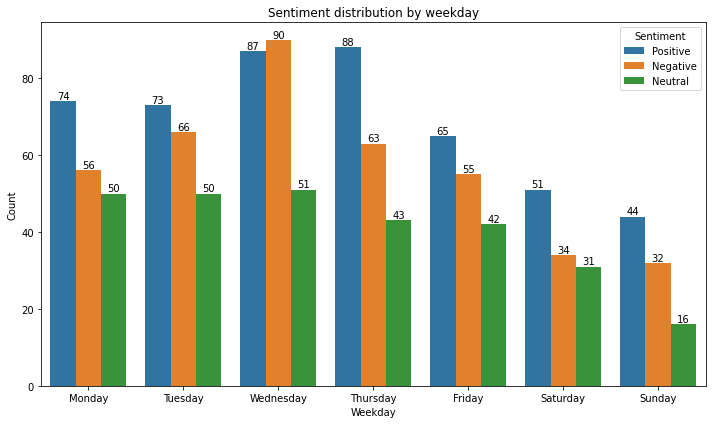

In [116]:
#plot sentiment distribution by weekday
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='weekday', hue='sentiment', data=total_subs, order=days_order)
plt.title("Sentiment distribution by weekday")
plt.xlabel("Weekday")
plt.ylabel("Count")
plt.legend(title="Sentiment")

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height, height, ha='center', va='bottom')

plt.tight_layout()
plt.show()


It is interesting to see that on the day with the most submissons there are mostly positive and neutral sentiment.

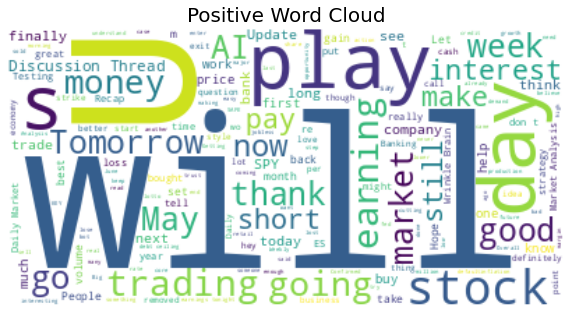

In [117]:
#filter only rows with "Positive" in column "sentiment"
positive_rows = total_subs.loc[total_subs['sentiment'] == "Positive"].drop_duplicates().dropna()

#combine text from title and comment
positive_texts = positive_rows['comment'] + positive_rows['title']

#Ttokenize
word_tokens = [word_tokenize(text) for text in positive_texts]
english_words = set(corpus.words.words())
word_cloud_string = ""

for word_list in word_tokens:
    for word in word_list:
        if word.lower() in english_words:
            word_cloud_string += word + " "

description_stopwords = set(STOPWORDS)

my_word_cloud = WordCloud(background_color='white', stopwords=description_stopwords).generate(word_cloud_string)
plt.figure(figsize=(10, 20))
plt.imshow(my_word_cloud, interpolation='bilinear')
plt.title("Positive Word Cloud", fontsize=20)
plt.axis('off')
plt.show()


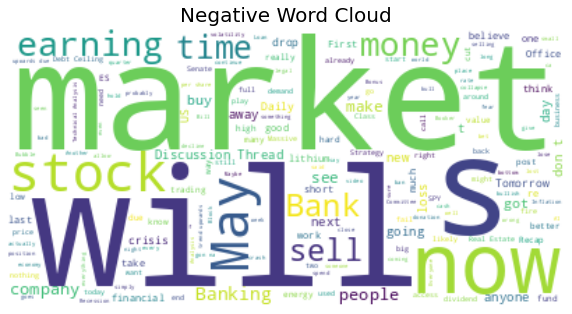

In [118]:
#filter only rows with "Negative" in column "sentiment"
negative_rows = total_subs.loc[total_subs['sentiment'] == "Negative"].drop_duplicates().dropna()

#combine text from title and comment
negative_texts = negative_rows['comment'] + negative_rows['title']

#Ttokenize
word_tokens = [word_tokenize(text) for text in negative_texts]
english_words = set(corpus.words.words())
word_cloud_string = ""

for word_list in word_tokens:
    for word in word_list:
        if word.lower() in english_words:
            word_cloud_string += word + " "

description_stopwords = set(STOPWORDS)

my_word_cloud = WordCloud(background_color='white', stopwords=description_stopwords).generate(word_cloud_string)
plt.figure(figsize=(10, 20))
plt.imshow(my_word_cloud, interpolation='bilinear')
plt.title("Negative Word Cloud", fontsize=20)
plt.axis('off')
plt.show()


# Conclusion


**The hypothesis could not be proven. Unfortunately, no clear sentiment was achieved and also in the Word Clouds no terms can be seen which indicate a trend.**

## Sentiment Analysis for submissions containing 'AAPL' in title or comment

In [108]:
#create new DataFrame with only submissions containing "AAPL" in "title" or "comment" column
aapl = total_subs[total_subs['title'].str.contains("AAPL") | total_subs['comment'].str.contains("AAPL")]
aapl = aapl.reset_index(drop=True)


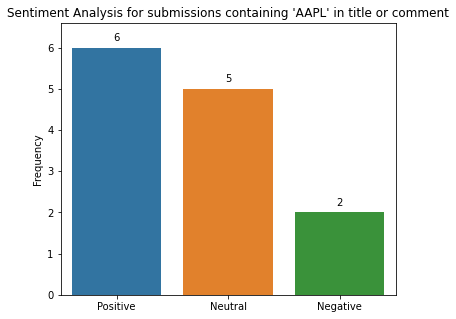

Percentage of Positive Sentiments: 46.15%
Percentage of Neutral Sentiments: 38.46%
Percentage of Negative Sentiments: 15.38%


In [114]:
fig, axis1 = plt.subplots(figsize=(6, 5))


value_counts = aapl['sentiment'].value_counts()
xs = [x for x in order if x in value_counts.index]
ys = [value_counts[x] for x in xs]

sns.barplot(x=xs, y=ys, order=order, ax=axis1)

axis1.set_title("Sentiment Analysis for submissions containing 'AAPL' in title or comment")
axis1.set_ylabel("Frequency")

# Add value labels above each bar
for i, v in enumerate(ys):
    axis1.annotate(str(v), xy=(i, v), xytext=(0, 5), ha='center', va='bottom', textcoords="offset points")

# Adjust y-axis limit to accommodate highest value
axis1.set_ylim(top=max(ys) * 1.1)

plt.show()
#print sentiment counts in percentage
sentiment_counts = aapl['sentiment'].value_counts()
total_count = len(aapl)

percentage_positive = (sentiment_counts['Positive'] / total_count) * 100
percentage_neutral = (sentiment_counts['Neutral'] / total_count) * 100
percentage_negative = (sentiment_counts['Negative'] / total_count) * 100

print(f"Percentage of Positive Sentiments: {percentage_positive:.2f}%")
print(f"Percentage of Neutral Sentiments: {percentage_neutral:.2f}%")
print(f"Percentage of Negative Sentiments: {percentage_negative:.2f}%")

As a bonus, we ran a sentiment analysis for submissions which contained 'AAPL' in "title" or "comment". Unfortunately, there were only 13 out of 1161 rows after filtering the posts and comments, which is why no meaningful sentiment analysis was possible.

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

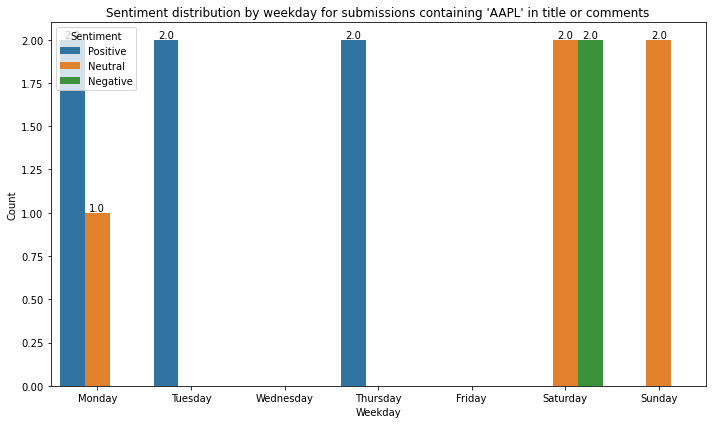

In [113]:
#plot sentiment distribution by weekday for submissions which contain 'AAPL' in title or comment
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='weekday', hue='sentiment', data=aapl, order=days_order)
plt.title("Sentiment distribution by weekday for submissions containing 'AAPL' in title or comments")
plt.xlabel("Weekday")
plt.ylabel("Count")
plt.legend(title="Sentiment")

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height, height, ha='center', va='bottom')

plt.tight_layout()
plt.show()